In [ ]:
import cv2
import os
import glob
from tqdm import tqdm

# ================= CONFIGURATION =================
# Point this to the folder containing '01', '02', etc.
# Based on your screenshot, it ends in 'testing_videos'
dataset_root = r"/kaggle/working/denoised_dataset"


# Where to save the output MP4 files
output_folder = "rendered_videos"

# Frame rate (Frames Per Second). 
# 25 or 30 is standard. Lower it (e.g., 10) if the video feels too fast.
fps = 25 
# =================================================

def create_video_from_frames(video_folder_path, output_path, fps):
    # 1. Find all images (jpg, png, jpeg)
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        images.extend(glob.glob(os.path.join(video_folder_path, ext)))
    
    if not images:
        print(f"No images found in {video_folder_path}")
        return

    # 2. Sort them numerically! 
    # Standard sort usually fails on "frame_1" vs "frame_10", 
    # but your data has padding (0093), so standard sort usually works.
    # We use a lambda just to be safe.
    try:
        images.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    except:
        images.sort() # Fallback if naming convention is different

    # 3. Read the first frame to get dimensions
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape
    size = (width, height)

    # 4. Initialize VideoWriter
    # 'mp4v' is a standard codec for .mp4
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    # 5. Write frames
    video_name = os.path.basename(output_path)
    for image_path in tqdm(images, desc=f"Rendering {video_name}", unit="frame"):
        img = cv2.imread(image_path)
        out.write(img)

    out.release()
    print(f"Saved: {output_path}")

def main():
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get list of video directories (01, 02, etc.)
    # We assume directories inside 'testing_videos' are the video clips
    video_dirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
    video_dirs.sort()

    print(f"Found {len(video_dirs)} video folders. Starting conversion...")

    for video_dir in video_dirs:
        full_path = os.path.join(dataset_root, video_dir)
        save_path = os.path.join(output_folder, f"video_{video_dir}.mp4")
        
        create_video_from_frames(full_path, save_path, fps)

    print("\nDone! Check the 'rendered_videos' folder.")

if __name__ == "__main__":
    main()

In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/input/vlg-rot/pytorch/default/1/rotnet_model(1).pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

In [ ]:
# 1. Clone the Repo
!git clone https://github.com/m-tassano/fastdvdnet.git
%cd fastdvdnet

# 2. Install Dependencies (Kaggle usually has these, but just in case)
!pip install -q torch torchvision opencv-python

# 3. Download Pre-trained Weights (Model.pth)
# We use the 'denoising' weights trained on high noise
!mkdir -p model
!wget -O model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth

In [ ]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/working/cleaned_testing_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
# Update this to match your actual file name (e.g., ep1.pth is Epoch 2 if 0-indexed)
MODEL_PATH = '/kaggle/input/vlg-unetmodelep8/pytorch/default/1/unet_conditional_ep8.pth' 
TEST_DIR = '/kaggle/working/denoised_dataset'
TARGET_VIDEO = '17' 

IMG_SIZE = 256
CLIP_LEN = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. MODEL ARCHITECTURE (Must be defined to load weights) ---
class AsymmetricConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(AsymmetricConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size//2, 0))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size//2))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x): return self.relu(self.bn(self.conv2(self.relu(self.conv1(x)))))

class ResidualSkipConnection(nn.Module):
    def __init__(self, channels):
        super(ResidualSkipConnection, self).__init__()
        self.block = nn.Sequential(AsymmetricConv(channels, channels), AsymmetricConv(channels, channels))
        self.shortcut = nn.Conv2d(channels, channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.block(x) + self.shortcut(x))

class ShortcutInceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutInceptionModule, self).__init__()
        w_6 = out_channels // 6; w_3 = out_channels // 3; w_2 = out_channels - (w_6 + w_3)
        self.branch1 = AsymmetricConv(in_channels, w_6)
        self.branch2 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3))
        self.branch3 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3), AsymmetricConv(w_3, w_2))
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(torch.cat([self.branch1(x), self.branch2(x), self.branch3(x)], dim=1) + self.shortcut(x))

class MultiScaleUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=3):
        super(MultiScaleUNet, self).__init__()
        self.sim1 = ShortcutInceptionModule(in_channels, 96); self.pool1 = nn.MaxPool2d(2)
        self.sim2 = ShortcutInceptionModule(96, 192);         self.pool2 = nn.MaxPool2d(2)
        self.sim3 = ShortcutInceptionModule(192, 384);        self.pool3 = nn.MaxPool2d(2)
        self.sim4 = ShortcutInceptionModule(384, 768)
        self.rsc1 = nn.Sequential(*[ResidualSkipConnection(96) for _ in range(4)])
        self.rsc2 = nn.Sequential(*[ResidualSkipConnection(192) for _ in range(3)])
        self.rsc3 = nn.Sequential(*[ResidualSkipConnection(384) for _ in range(2)])
        self.sim5 = ShortcutInceptionModule(768, 384);   self.up1 = nn.ConvTranspose2d(384, 384, 2, 2)
        self.sim6 = ShortcutInceptionModule(768, 192);   self.up2 = nn.ConvTranspose2d(192, 192, 2, 2)
        self.sim7 = ShortcutInceptionModule(384, 96);    self.up3 = nn.ConvTranspose2d(96, 96, 2, 2)
        self.sim8 = ShortcutInceptionModule(192, 96)
        self.final = nn.Conv2d(96, out_channels, 3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        e1 = self.sim1(x); p1 = self.pool1(e1)
        e2 = self.sim2(p1); p2 = self.pool2(e2)
        e3 = self.sim3(p2); p3 = self.pool3(e3)
        e4 = self.sim4(p3)
        d1 = self.sim5(e4); u1 = self.up1(d1)
        d2 = self.sim6(torch.cat([u1, self.rsc3(e3)], dim=1)); u2 = self.up2(d2)
        d3 = self.sim7(torch.cat([u2, self.rsc2(e2)], dim=1)); u3 = self.up3(d3)
        d4 = self.sim8(torch.cat([u3, self.rsc1(e1)], dim=1))
        return self.tanh(self.final(d4))

# --- 2. SINGLE VIDEO DATASET ---
class SingleVideoDataset(Dataset):
    def __init__(self, vid_id, root_dir, clip_len=4, img_size=256):
        self.clip_len = clip_len
        self.samples = []
        
        # Locate Video
        vid_path = os.path.join(root_dir, vid_id)
        if not os.path.exists(vid_path):
            # Try finding folder with different zero-padding (e.g. '2' vs '02')
            candidates = [d for d in os.listdir(root_dir) if str(int(d)) == str(int(vid_id))]
            if candidates: vid_path = os.path.join(root_dir, candidates[0])
            else: raise ValueError(f"Video {vid_id} not found in {root_dir}")
            
        print(f"Loading frames from {vid_path}...")
        self.frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Create sliding windows
        if len(self.frames) >= clip_len + 1:
            for i in range(len(self.frames) - clip_len):
                self.samples.append(i)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        # Input: [t, t+1, t+2, t+3]
        in_paths = self.frames[idx : idx + self.clip_len]
        # Target: [t+4]
        tgt_path = self.frames[idx + self.clip_len]
        
        imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        input_seq = torch.cat(imgs, dim=0) # (12, H, W)
        target = self.transform(Image.open(tgt_path).convert('RGB'))
        
        return input_seq, target, idx + self.clip_len

# --- 3. PLOT LOGIC ---
def visualize():
    print(f"Generating Anomaly Graph for Video {TARGET_VIDEO} using {MODEL_PATH}...")
    
    # Load Model
    model = MultiScaleUNet().to(DEVICE)
    if not os.path.exists(MODEL_PATH):
        print(f"Error: {MODEL_PATH} not found. Please train first or check the path.")
        return
        
    st = torch.load(MODEL_PATH, map_location=DEVICE)
    # Handle DataParallel dict keys if needed
    if 'module.' in list(st.keys())[0]: st = {k.replace('module.', ''): v for k, v in st.items()}
    model.load_state_dict(st)
    model.eval()
    
    # Data
    ds = SingleVideoDataset(TARGET_VIDEO, TEST_DIR, CLIP_LEN, IMG_SIZE)
    loader = DataLoader(ds, batch_size=16, shuffle=False, num_workers=2)
    
    frame_indices = []
    errors = []
    
    # Inference
    with torch.no_grad():
        for inputs, targets, idxs in tqdm(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            preds = model(inputs)
            
            # Calculate Reconstruction Error (MSE) per frame
            # (Batch, C, H, W) -> Mean over (C, H, W) -> (Batch)
            mse = ((preds - targets)**2).mean(dim=(1,2,3)).cpu().numpy()
            
            errors.extend(mse)
            frame_indices.extend(idxs.numpy())
            
    # Process Scores
    scores = np.array(errors)
    
    # Normalize [0, 1] for this video (Crucial for AP!)
    mn, mx = scores.min(), scores.max()
    if mx > mn:
        scores_norm = (scores - mn) / (mx - mn)
    else:
        scores_norm = scores
        
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(frame_indices, scores_norm, color='red', linewidth=2, label='Anomaly Score (Normalized MSE)')
    
    plt.title(f"Anomaly Score Profile: Video {TARGET_VIDEO} (Epoch 2 Model)", fontsize=16)
    plt.xlabel("Frame Number")
    plt.ylabel("Anomaly Score (0=Normal, 1=Anomaly)")
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    visualize()

In [ ]:
import os
import glob
import re
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.nn as nn

# ================= CONFIGURATION =================
MODEL_PATH = '/kaggle/input/vlg-unetmodelep8/pytorch/default/1/unet_conditional_ep8.pth' 
CLEAN_DIR = '/kaggle/working/denoised_dataset' 

# Path to original noisy frames (for correct IDs like 939)
# CONFIRM THIS PATH IS CORRECT on your system
ORIGINAL_TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

SUBMISSION_FILE = 'submission.csv'

IMG_SIZE = 256
CLIP_LEN = 4
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- HELPER: NATURAL SORT ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# --- 1. MODEL ARCHITECTURE ---
class AsymmetricConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(AsymmetricConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size//2, 0))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size//2))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x): return self.relu(self.bn(self.conv2(self.relu(self.conv1(x)))))

class ResidualSkipConnection(nn.Module):
    def __init__(self, channels):
        super(ResidualSkipConnection, self).__init__()
        self.block = nn.Sequential(AsymmetricConv(channels, channels), AsymmetricConv(channels, channels))
        self.shortcut = nn.Conv2d(channels, channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.block(x) + self.shortcut(x))

class ShortcutInceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutInceptionModule, self).__init__()
        w_6 = out_channels // 6; w_3 = out_channels // 3; w_2 = out_channels - (w_6 + w_3)
        self.branch1 = AsymmetricConv(in_channels, w_6)
        self.branch2 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3))
        self.branch3 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3), AsymmetricConv(w_3, w_2))
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(torch.cat([self.branch1(x), self.branch2(x), self.branch3(x)], dim=1) + self.shortcut(x))

class MultiScaleUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=3):
        super(MultiScaleUNet, self).__init__()
        self.sim1 = ShortcutInceptionModule(in_channels, 96); self.pool1 = nn.MaxPool2d(2)
        self.sim2 = ShortcutInceptionModule(96, 192);         self.pool2 = nn.MaxPool2d(2)
        self.sim3 = ShortcutInceptionModule(192, 384);        self.pool3 = nn.MaxPool2d(2)
        self.sim4 = ShortcutInceptionModule(384, 768)
        self.rsc1 = nn.Sequential(*[ResidualSkipConnection(96) for _ in range(4)])
        self.rsc2 = nn.Sequential(*[ResidualSkipConnection(192) for _ in range(3)])
        self.rsc3 = nn.Sequential(*[ResidualSkipConnection(384) for _ in range(2)])
        self.sim5 = ShortcutInceptionModule(768, 384);   self.up1 = nn.ConvTranspose2d(384, 384, 2, 2)
        self.sim6 = ShortcutInceptionModule(768, 192);   self.up2 = nn.ConvTranspose2d(192, 192, 2, 2)
        self.sim7 = ShortcutInceptionModule(384, 96);    self.up3 = nn.ConvTranspose2d(96, 96, 2, 2)
        self.sim8 = ShortcutInceptionModule(192, 96)
        self.final = nn.Conv2d(96, out_channels, 3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        e1 = self.sim1(x); p1 = self.pool1(e1)
        e2 = self.sim2(p1); p2 = self.pool2(e2)
        e3 = self.sim3(p2); p3 = self.pool3(e3)
        e4 = self.sim4(p3)
        d1 = self.sim5(e4); u1 = self.up1(d1)
        d2 = self.sim6(torch.cat([u1, self.rsc3(e3)], dim=1)); u2 = self.up2(d2)
        d3 = self.sim7(torch.cat([u2, self.rsc2(e2)], dim=1)); u3 = self.up3(d3)
        d4 = self.sim8(torch.cat([u3, self.rsc1(e1)], dim=1))
        return self.tanh(self.final(d4))

# --- 2. DATASET (Reads CLEANED frames) ---
class CleanVideoDataset(Dataset):
    def __init__(self, vid_id, root_dir, clip_len=4, img_size=256):
        self.clip_len = clip_len
        self.samples = []
        vid_path = os.path.join(root_dir, vid_id)
        # Assumes frame_0000.jpg format (from FastDVDnet output)
        self.frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        if len(self.frames) >= clip_len + 1:
            for i in range(len(self.frames) - clip_len):
                self.samples.append(i)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        in_paths = self.frames[idx : idx + self.clip_len]
        tgt_path = self.frames[idx + self.clip_len]
        imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        input_seq = torch.cat(imgs, dim=0)
        target = self.transform(Image.open(tgt_path).convert('RGB'))
        return input_seq, target

# --- 3. MAIN LOGIC ---
def extract_frame_id(filename):
    """
    Extracts 939 from 'frame_00939.jpg' or '939.jpg'
    """
    # Regex to find the LAST sequence of digits in the filename
    match = re.search(r'(\d+)', os.path.splitext(filename)[0])
    if match:
        return int(match.group(1))
    return None

def generate_final_submission():
    print("🚀 Generating Final Corrected Submission...")
    
    # 1. Load Model
    model = MultiScaleUNet()
    if not os.path.exists(MODEL_PATH):
        print("❌ Model not found."); return
    
    st = torch.load(MODEL_PATH, map_location='cpu')
    if 'module.' in list(st.keys())[0]: st = {k.replace('module.', ''): v for k, v in st.items()}
    model.load_state_dict(st)
    model.to(DEVICE)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model.eval()
    
    # 2. Iterate Videos
    video_folders = sorted([f for f in os.listdir(CLEAN_DIR) if os.path.isdir(os.path.join(CLEAN_DIR, f))])
    all_results = []
    
    for vid_id in video_folders:
        print(f"🎬 Processing Video {vid_id}...", end=" ")
        
        # --- A. Get Correct Frame IDs from Original Folder ---
        orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, vid_id)
        if not os.path.exists(orig_vid_path):
             candidates = [d for d in os.listdir(ORIGINAL_TEST_DIR) if str(int(d)) == str(int(vid_id))]
             if candidates: orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, candidates[0])
        
        # Grab all frames (frame_00939.jpg)
        orig_files = glob.glob(os.path.join(orig_vid_path, '*'))
        orig_files = [f for f in orig_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        orig_files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        # Extract Real IDs (e.g., 939, 940...)
        real_frame_ids = []
        for f in orig_files:
            fid = extract_frame_id(os.path.basename(f))
            if fid is not None:
                real_frame_ids.append(fid)
                
        if not real_frame_ids:
            print(f"⚠️ No frames found in original {vid_id}. Skipping.")
            continue
            
        # --- B. Inference ---
        ds = CleanVideoDataset(vid_id, CLEAN_DIR, CLIP_LEN, IMG_SIZE)
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        
        raw_scores = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                preds = model(inputs)
                batch_mse = ((preds - targets)**2).mean(dim=(1,2,3)).cpu().numpy()
                raw_scores.extend(batch_mse)
        
        # --- C. Normalization ---
        scores_arr = np.array(raw_scores)
        if len(scores_arr) > 0:
            mn, mx = scores_arr.min(), scores_arr.max()
            if mx > mn: scores_norm = (scores_arr - mn) / (mx - mn)
            else: scores_norm = scores_arr
        else:
            scores_norm = []
        
        # --- D. Mapping ---
        # 1. The first 4 frames (CLIP_LEN) have NO prediction -> fill 0.0
        # 2. Prediction 0 aligns with Frame Index 4 (5th frame)
        
        count_mapped = 0
        for i, real_id in enumerate(real_frame_ids):
            if i < CLIP_LEN:
                # Fill buffer frames
                score = 0.0
            else:
                # Use prediction if available
                pred_idx = i - CLIP_LEN
                if pred_idx < len(scores_norm):
                    score = scores_norm[pred_idx]
                else:
                    score = 0.0 # Should not happen if lengths align
            
            all_results.append({
                'video_id': vid_id,
                'frame_id': real_id,
                'anomaly_score': float(score)
            })
            count_mapped += 1
            
        print(f"Done. ({count_mapped} frames)")

    # 3. Save
    df = pd.DataFrame(all_results)
    df['video_id'] = df['video_id'].astype(str)
    df.sort_values(by=['video_id', 'frame_id'], inplace=True)
    
    df.to_csv(SUBMISSION_FILE, index=False)
    print(f"\n✅✅✅ FINAL SUBMISSION SAVED: {SUBMISSION_FILE}")
    print("Example (Video 01):")
    print(df[df['video_id'].isin(['01', '1'])].head(6))

if __name__ == "__main__":
    generate_final_submission()

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import re # Added for safer number extraction

# ================= CONFIGURATION =================

RGB_TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'
INPUT_CSV = '/kaggle/input/stae-cleaned-flow/submission_stae_flow_dual_gpu.csv'
OUTPUT_CSV = 'final_submission.csv'
T_STEPS = 4 
# =================================================

def extract_frame_num(filename):
    # Extracts numbers from 'frame_01094.jpg' -> 1094
    # Finds the last sequence of digits in the filename
    matches = re.findall(r'(\d+)', filename)
    if matches:
        return int(matches[-1]) # Takes the last number found (01094)
    return None

def reconstruct_final():
    if not os.path.exists(INPUT_CSV):
        print(f"❌ Error: {INPUT_CSV} not found.")
        return

    raw_df = pd.read_csv(INPUT_CSV)
    all_predictions = raw_df['Predicted'].tolist()
    
    print(f"📥 Loaded {len(all_predictions)} predictions.")
    
    # Sort folders numerically (1, 2, ... 10)
    video_ids = sorted(
        [d for d in os.listdir(RGB_TEST_DIR) if os.path.isdir(os.path.join(RGB_TEST_DIR, d))],
        key=lambda x: int(x) if x.isdigit() else x
    )

    final_rows = []
    preds_idx = 0 

    for vid in video_ids:
        vid_path = os.path.join(RGB_TEST_DIR, vid)
        
        # Get all jpg files
        files = glob.glob(os.path.join(vid_path, '*.jpg'))
        
        # Create a list of (frame_number, full_path) tuples
        frame_data = []
        for f in files:
            f_num = extract_frame_num(os.path.basename(f))
            if f_num is not None:
                frame_data.append(f_num)
        
        # Sort by frame number (Crucial!)
        frame_nums = sorted(frame_data)
        
        total_frames = len(frame_nums)
        if total_frames == 0:
            print(f"⚠️ Video {vid}: Found 0 valid images.")
            continue

        # Expected predictions = Total Frames - Warmup Steps
        expected_preds = total_frames - T_STEPS
        
        if expected_preds <= 0:
            print(f"⚠️ Video {vid}: Not enough frames ({total_frames}). Skipping.")
            continue

        # Check if we have enough predictions left
        if preds_idx + expected_preds > len(all_predictions):
            print(f"❌ Error: Running out of predictions at Video {vid}!")
            print(f"   Needed {expected_preds}, but only {len(all_predictions) - preds_idx} remain.")
            break
            
        # Extract predictions for this video
        vid_scores = all_predictions[preds_idx : preds_idx + expected_preds]
        preds_idx += expected_preds 
        
        # --- NORMALIZE (Video-Wise) ---
        v_scores = np.array(vid_scores)
        v_min, v_max = v_scores.min(), v_scores.max()
        
        if v_max > v_min:
            norm_scores = (v_scores - v_min) / (v_max - v_min)
        else:
            norm_scores = np.zeros_like(v_scores)

        # --- FILL CSV ---
        # 1. Warm-up frames (e.g. first 4 frames) -> Set to 0.0
        for i in range(T_STEPS):
            actual_num = frame_nums[i]
            final_rows.append({
                'ID': f"{int(vid)}_{actual_num}", # e.g. 1_1094
                'Predicted': 0.0
            })
            
        # 2. Predicted frames
        for i, score in enumerate(norm_scores):
            actual_num = frame_nums[i + T_STEPS]
            final_rows.append({
                'ID': f"{int(vid)}_{actual_num}", 
                'Predicted': score
            })
            
        print(f"✅ Video {vid}: {total_frames} frames ({frame_nums[0]} -> {frame_nums[-1]})")

    # Final Save
    if final_rows:
        df_final = pd.DataFrame(final_rows)
        df_final.to_csv(OUTPUT_CSV, index=False)
        print(f"\n🎉 SUCCESS! Saved {len(df_final)} rows to {OUTPUT_CSV}")
    else:
        print("\n❌ Failed to generate rows.")

if __name__ == "__main__":
    reconstruct_final()

In [ ]:
import pandas as pd

# ================= CONFIGURATION =================
# Path to the CSV you just generated (with video_id, frame_id, score)
INPUT_CSV = 'submission.csv' 
OUTPUT_CSV = 'submission_final.csv'
# =================================================

def format_submission():
    print(f"📂 Loading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    # 1. Ensure clean integer types
    # This automatically turns "01" into 1, handling the leading zero removal
    df['video_id'] = df['video_id'].astype(int)
    df['frame_id'] = df['frame_id'].astype(int)
    
    # 2. Create the merged 'ID' column (Format: 1_939)
    print("🔄 Merging columns to 'videoID_frameID' format...")
    df['ID'] = df['video_id'].astype(str) + "_" + df['frame_id'].astype(str)
    
    # 3. Select ONLY the required columns
    final_df = df[['ID', 'anomaly_score']]
    
    # 4. Fill any remaining NaNs with 0.0 (Just in case)
    final_df['anomaly_score'] = final_df['anomaly_score'].fillna(0.0)
    
    # 5. Save
    final_df.to_csv(OUTPUT_CSV, index=False)
    
    print(f"✅ SUCCESS! Final file saved to: {OUTPUT_CSV}")
    print("Example Rows:")
    print(final_df.head())

if __name__ == "__main__":
    format_submission()

In [ ]:
!pip install "numpy<2"


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/input/vlg-jr-raw/final_submission(3).csv'
OUTPUT_CSV = 'submission_processed.csv'

# The "Center" of your sigmoid (The threshold between Normal vs Anomaly)
# You observed normals are < 0.1, so 0.1 is the tipping point.
CENTER = 0.1

# How hard to push values to 0 and 1.
# Low (e.g. 10) = Gentle S-curve
# High (e.g. 50) = Hard Step Function (Almost binary)
STEEPNESS = 10
# =================================================

def sigmoid_transform(x, center, k):
    """
    Custom Sigmoid:
    x: Input score array
    center: The value that maps to 0.5 (tipping point)
    k: Steepness coefficient
    """
    # 1. Shift x so the center is at 0
    shifted = x - center
    
    # 2. Scale by steepness
    scaled = k * shifted
    
    # 3. Apply standard sigmoid: 1 / (1 + e^-x)
    return 1 / (1 + np.exp(-scaled))

def process_and_visualize():
    print(f"📂 Loading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    original_scores = df['Predicted'].values
    
    # --- APPLY TRANSFORM ---
    print(f"⚡ Applying Sigmoid (Center={CENTER}, Steepness={STEEPNESS})...")
    new_scores = sigmoid_transform(original_scores, CENTER, STEEPNESS)
    
    df['Predicted'] = new_scores
    
    # --- VISUALIZATION (THE "U" GRAPH) ---
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Original Distribution
    plt.subplot(1, 2, 1)
    plt.hist(original_scores, bins=50, color='blue', alpha=0.7)
    plt.axvline(CENTER, color='red', linestyle='--', label=f'Center ({CENTER})')
    plt.title("Original Scores (Before)")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Processed Distribution (Should look like a U)
    plt.subplot(1, 2, 2)
    plt.hist(new_scores, bins=50, color='green', alpha=0.7)
    plt.title(f"Processed Scores (After)\nSteepness: {STEEPNESS}")
    plt.xlabel("Score (0=Normal, 1=Anomaly)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("score_distribution_u_graph.png")
    print("📸 Saved visualization to 'score_distribution_u_graph.png'")
    plt.show()
    
    # --- SAVE ---
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ Saved processed scores to {OUTPUT_CSV}")
    print(df.head())

if __name__ == "__main__":
    process_and_visualize()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# Use the file that gave you 0.66
INPUT_CSV = '/kaggle/working/submission_processed.csv' 
OUTPUT_CSV = 'submission_boosted2.csv'

# DILATION WINDOW
# Avenue is 25fps. Events last ~1-2 seconds.
# A window of 25 means we look +/- 12 frames around a peak.
WINDOW_SIZE = 10
# =================================================

def boost_score():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    df['VideoID'] = df['ID'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    print(f"Applying Peak Widening (Window={WINDOW_SIZE})...")
    
    for vid, group in df.groupby('VideoID', sort=False):
        raw = group['Predicted'].copy()
        
        # 1. ROLLING MAX (Dilation)
        # This spreads the '1.0' scores to their neighbors.
        # "If frame T is bad, then frame T+1 is probably bad too."
        dilated = raw.rolling(window=WINDOW_SIZE, center=True, min_periods=1).max()
        
        # 2. LIGHT SMOOTHING (Average)
        # Rolling max creates "blocky" steps. We smooth the edges slightly.
        smoothed = dilated.rolling(window=10, center=True, min_periods=1).mean()
        
        
        
        final_preds.extend(smoothed.values)
        
    df['Predicted'] = final_preds
    
    # Final Normalize (Safety)
    df['Predicted'] = np.clip(df['Predicted'], 0.0, 1.0)
    
    # --- VISUALIZATION ---
    # Let's see how much "fatter" the detection became
    v05 = df[df['ID'].str.startswith('05_')]
    if not v05.empty:
        x = v05['ID'].apply(lambda x: int(x.split('_')[1]))
        plt.figure(figsize=(15, 5))
        
        # We need to reload original to compare
        orig = pd.read_csv(INPUT_CSV)
        orig_v05 = orig[orig['ID'].str.startswith('05_')]
        
        plt.plot(x, orig_v05['Predicted'], color='gray', alpha=0.5, label='Original (0.66)')
        plt.plot(x, v05['Predicted'], color='green', linewidth=2, label='Widened (Boosted)')
        
        plt.title("Peak Widening Effect (Video 05)")
        plt.legend()
        plt.show()

    # Save
    out = df[['ID', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved boosted scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    boost_score()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/working/submission_boosted2.csv'
THRESHOLD = 0.5 
# =================================================

def visualize_inline():
    print(f"📂 Loading {INPUT_CSV}...")
    try:
        df = pd.read_csv(INPUT_CSV)
    except FileNotFoundError:
        print("❌ Error: File not found. Did you run the previous step?")
        return

    # 1. Parse 'ID' (e.g., '1_939') back into Video and Frame columns
    print("🔄 Parsing data...")
    split_data = df['ID'].str.split('_', expand=True)
    df['video_id'] = split_data[0].astype(int)
    df['frame_id'] = split_data[1].astype(int)
    
    # 2. Get unique videos
    videos = sorted(df['video_id'].unique())
    print(f"🌍 Visualizing {len(videos)} videos...")
    print("-" * 30)

    # 3. Loop and Plot Inline
    for vid in videos:
        # Filter data for this video
        vid_df = df[df['video_id'] == vid].sort_values(by='frame_id')
        
        frames = vid_df['frame_id'].values
        scores = vid_df['Predicted'].values
        
        # Create Plot
        plt.figure(figsize=(14, 4)) # Wide and short for better scrolling
        
        # Plot the Score Line
        plt.plot(frames, scores, color='#007acc', linewidth=2, label='Anomaly Score')
        
        # Fill area under curve for anomalies (Red Zones)
        plt.fill_between(frames, scores, THRESHOLD, where=(scores >= THRESHOLD), 
                         interpolate=True, color='red', alpha=0.3, label='Anomaly Detected')
        
        # Add Threshold Line
        plt.axhline(y=THRESHOLD, color='black', linestyle='--', alpha=0.5)
        
        # Styling
        plt.title(f"Video {vid}: Anomaly Profile", fontsize=14, fontweight='bold')
        plt.xlabel("Frame Number")
        plt.ylabel("Score")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right')
        
        # SHOW PLOT
        plt.show()
        print("\n") # Spacing

if __name__ == "__main__":
    visualize_inline()

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS
CLEAN_TEST_DIR = '/kaggle/working/denoised_dataset' 

# 2. Path to your saved LITE model
MODEL_PATH = '/kaggle/input/vlg-roadmap/pytorch/default/1/roadmap_lite_model.pth'

IMG_SIZE = 256
T_STEPS = 4  # Must match what you trained with
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. RE-DEFINE ARCHITECTURE (Must match training exactly) ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        
        # Lite Paths (Direct GRU)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)

    def forward(self, frames):
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
            
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 2. PSNR CALCULATION FUNCTION ---
def calc_psnr(pred, target):
    # Denormalize first: tanh output is [-1, 1] -> [0, 1]
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    
    mse = torch.mean((pred - target) ** 2, dim=[1, 2, 3]) # Mean per image
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# --- 3. MAIN VISUALIZATION FUNCTION ---
def visualize_video(vid_id):
    print(f"Visualizing Video: {vid_id}")
    
    # Locate Video
    vid_path = os.path.join(CLEAN_TEST_DIR, str(vid_id).zfill(2)) # Handle "1" vs "01"
    if not os.path.exists(vid_path):
        # Try finding folder regardless of leading zero
        candidates = [d for d in os.listdir(CLEAN_TEST_DIR) if str(int(d)) == str(int(vid_id))]
        if not candidates:
            print(f"Error: Video {vid_id} not found in {CLEAN_TEST_DIR}")
            return
        vid_path = os.path.join(CLEAN_TEST_DIR, candidates[0])
        
    frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
    print(f"Found {len(frames)} frames.")
    
    # Load Model
    model = ROADMAP_LITE()
    if os.path.exists(MODEL_PATH):
        state = torch.load(MODEL_PATH, map_location=DEVICE)
        # Handle DataParallel cleaning
        new_state = {k.replace('module.', ''): v for k, v in state.items()}
        model.load_state_dict(new_state)
    else:
        print("Model file not found!")
        return
    
    model.to(DEVICE)
    model.eval()
    
    # Transform
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    
    psnr_list = []
    frame_indices = []
    
    print("Running Inference...")
    with torch.no_grad():
        for i in range(len(frames) - T_STEPS):
            # Input: T frames
            clip = frames[i : i + T_STEPS]
            # Target: The NEXT frame (T+1)
            target_path = frames[i + T_STEPS]
            
            input_imgs = [tf(Image.open(p).convert('RGB')) for p in clip]
            target_img = tf(Image.open(target_path).convert('RGB')).unsqueeze(0).to(DEVICE)
            
            input_tensor = torch.stack(input_imgs).unsqueeze(0).to(DEVICE) # (1, T, 3, H, W)
            
            # Predict
            pred_img = model(input_tensor)
            
            # Calculate Quality (PSNR)
            psnr = calc_psnr(pred_img, target_img)
            psnr_list.append(psnr)
            frame_indices.append(i + T_STEPS) # Mapping to the predicted frame index
            
    # --- 4. NORMALIZE TO ANOMALY SCORE ---
    # Paper Formula: S_t = 1 - (R_t - min(R)) / (max(R) - min(R)) 
    psnr_array = np.array(psnr_list)
    min_r = np.min(psnr_array)
    max_r = np.max(psnr_array)
    
    # Inverse: Low PSNR (Bad prediction) -> High Anomaly Score
    anomaly_scores = 1.0 - ((psnr_array - min_r) / (max_r - min_r))
    
    # --- 5. PLOT ---
    plt.figure(figsize=(15, 6))
    
    # Plot the signal
    plt.plot(frame_indices, anomaly_scores, color='#e74c3c', linewidth=2, label='Anomaly Score')
    
    # Add styling
    plt.title(f'Anomaly Detection: Video {vid_id} (ROADMAP Lite)', fontsize=16, fontweight='bold')
    plt.xlabel('Frame Number', fontsize=12)
    plt.ylabel('Anomaly Score (0=Normal, 1=Abnormal)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Threshold Hint')
    
    # Fill under curve for emphasis
    plt.fill_between(frame_indices, anomaly_scores, color='#e74c3c', alpha=0.1)
    
    plt.legend()
    plt.tight_layout()
    
    # Save and Show
    save_name = f'anomaly_plot_video_{vid_id}.png'
    plt.savefig(save_name)
    print(f"Plot saved to {save_name}")
    plt.show()

# ==========================================
# ENTER VIDEO NUMBER HERE
# ==========================================
target_video = "10"  # <--- Change this to whatever video you wish (e.g., "01", "12")
visualize_video(target_video)

In [ ]:
import os
import glob
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS (frame_0000.jpg style)
CLEAN_TEST_DIR = '/kaggle/working/denoised_dataset' 

# 2. Path to ORIGINAL NOISY VIDEOS (frame_00939.jpg style) - For ID mapping
ORIGINAL_TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# 3. Model Weights
MODEL_PATH = '/kaggle/input/vlg-roadmap/pytorch/default/1/roadmap_lite_model.pth'

SUBMISSION_FILE = 'submission_roadmap.csv'
IMG_SIZE = 256
T_STEPS = 4  # Sequence Length
BATCH_SIZE = 32 # Can be lower if OOM occurs (ROADMAP is heavier than U-Net)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. MODEL ARCHITECTURE ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)

    def forward(self, frames):
        # frames shape: (Batch, T, C, H, W)
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        
        # We only need the prediction for the LAST step, but we must run through T steps
        # Optimization: We don't need to store intermediates for backprop (inference mode)
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
            
        # Decode only the final state
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 2. DATASET ---
class RoadMapDataset(Dataset):
    def __init__(self, vid_id, root_dir, t_steps=4, img_size=256):
        self.t_steps = t_steps
        vid_path = os.path.join(root_dir, vid_id)
        self.frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.samples = []
        # We need T frames to predict T+1
        if len(self.frames) > t_steps:
            for i in range(len(self.frames) - t_steps):
                self.samples.append(i)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        # Input: T frames [0, 1, 2, 3]
        in_paths = self.frames[idx : idx + self.t_steps]
        # Target: Frame [4] (The one we are predicting)
        tgt_path = self.frames[idx + self.t_steps]
        
        imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        # Stack: (T, C, H, W)
        input_seq = torch.stack(imgs, dim=0) 
        target = self.transform(Image.open(tgt_path).convert('RGB'))
        
        return input_seq, target

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def extract_frame_id(filename):
    match = re.search(r'(\d+)', os.path.splitext(filename)[0])
    if match: return int(match.group(1))
    return None

# --- 3. MAIN GENERATION ---
def generate_roadmap_submission():
    print("🚀 Generating ROADMAP Submission...")
    
    # 1. Load Model
    model = ROADMAP_LITE()
    if not os.path.exists(MODEL_PATH):
        print("❌ Model weights not found!"); return
        
    st = torch.load(MODEL_PATH, map_location='cpu')
    if 'module.' in list(st.keys())[0]: st = {k.replace('module.', ''): v for k, v in st.items()}
    model.load_state_dict(st)
    
    model.to(DEVICE)
    if torch.cuda.device_count() > 1:
        print(f"🔥 Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model.eval()
    
    # 2. Iterate Videos
    video_folders = sorted([f for f in os.listdir(CLEAN_TEST_DIR) if os.path.isdir(os.path.join(CLEAN_TEST_DIR, f))])
    all_results = []
    
    for vid_id in video_folders:
        print(f"🎬 Processing Video {vid_id}...", end=" ")
        
        # --- A. Get Original IDs ---
        orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, vid_id)
        if not os.path.exists(orig_vid_path):
             # Fuzzy match for '2' vs '02'
             candidates = [d for d in os.listdir(ORIGINAL_TEST_DIR) if str(int(d)) == str(int(vid_id))]
             if candidates: orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, candidates[0])
        
        orig_files = glob.glob(os.path.join(orig_vid_path, '*'))
        orig_files = [f for f in orig_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        orig_files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        real_frame_ids = []
        for f in orig_files:
            fid = extract_frame_id(os.path.basename(f))
            if fid is not None: real_frame_ids.append(fid)
            
        if not real_frame_ids: continue
            
        # --- B. Inference ---
        ds = RoadMapDataset(vid_id, CLEAN_TEST_DIR, T_STEPS, IMG_SIZE)
        if len(ds) == 0: continue
            
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        
        psnr_list = []
        
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                
                # Forward
                preds = model(inputs) # (B, 3, H, W)
                
                # Denormalize [-1, 1] -> [0, 1] for PSNR calculation
                preds = (preds + 1) / 2
                targets = (targets + 1) / 2
                
                # PSNR Calculation per item in batch
                mse = torch.mean((preds - targets) ** 2, dim=[1, 2, 3])
                psnr = 10 * torch.log10(1 / mse)
                
                psnr_list.extend(psnr.cpu().numpy())
        
        # --- C. Normalization (Paper Formula) ---
        psnr_array = np.array(psnr_list)
        if len(psnr_array) > 0:
            min_r = np.min(psnr_array)
            max_r = np.max(psnr_array)
            
            # Inverse: Low PSNR = High Anomaly
            if max_r > min_r:
                scores_norm = 1.0 - ((psnr_array - min_r) / (max_r - min_r))
            else:
                scores_norm = np.zeros_like(psnr_array)
        else:
            scores_norm = []
            
        # --- D. Map & Save ---
        # Logic: First T_STEPS (4) frames have no score -> 0.0
        # Prediction 0 corresponds to Real Frame 4 (5th frame)
        
        clean_vid_num = int(vid_id)
        
        for i, real_id in enumerate(real_frame_ids):
            if i < T_STEPS:
                score = 0.0
            else:
                pred_idx = i - T_STEPS
                if pred_idx < len(scores_norm):
                    score = scores_norm[pred_idx]
                else:
                    score = 0.0
            
            merged_id = f"{clean_vid_num}_{real_id}"
            all_results.append({'ID': merged_id, 'Prediction': float(score)})
            
        print(f"Done. ({len(real_frame_ids)} frames)")
        
    # Save
    df = pd.DataFrame(all_results)
    
    # Sort
    df['temp_vid'] = df['ID'].apply(lambda x: int(x.split('_')[0]))
    df['temp_frame'] = df['ID'].apply(lambda x: int(x.split('_')[1]))
    df.sort_values(by=['temp_vid', 'temp_frame'], inplace=True)
    df.drop(columns=['temp_vid', 'temp_frame'], inplace=True)
    
    df.to_csv(SUBMISSION_FILE, index=False)
    print(f"\n✅✅✅ ROADMAP SUBMISSION SAVED: {SUBMISSION_FILE}")
    print(df.head())

if __name__ == "__main__":
    generate_roadmap_submission()

In [7]:
import pandas as pd
import os

# ================= CONFIGURATION =================
# 1. Path to U-Net
FILE_UNET = '/kaggle/input/unet-final2/submission_boosted2 (10).csv'

# 2. Path to ROADMAP
FILE_ROAD = '/kaggle/input/vlg-roadnet-final/submission_boosted2 (7).csv'

# 3. Path to STAE
FILE_STAE = '/kaggle/input/vlg-0-68-2/submission_boosted(1).csv' 

# 4. Path to NEW MODEL (Your 4th File)
FILE_NEW  = '/kaggle/input/jr-final-2/submission_boosted2 (14).csv' # <--- UPDATE THIS PATH

OUTPUT_FILE = 'submission_quad_ensemble.csv'

# WEIGHTS (Must sum to 1.0)
# Strategy: Strongest model gets the most weight. 
# Example: If STAE is best, give it 0.4. If the new one is weak, give it 0.1.
W_ROAD = 0.10
W_UNET = 0.10
W_STAE = 0.50
W_NEW  = 0.30
# =================================================

def quad_ensemble():
    print("🚀 Initiating The Quad Ensemble (ROADMAP + U-Net + STAE + NEW)...")
    
    try:
        # 1. Load Dataframes
        df_u = pd.read_csv(FILE_UNET)
        df_r = pd.read_csv(FILE_ROAD)
        
        # Check optional files
        df_s = pd.read_csv(FILE_STAE) if os.path.exists(FILE_STAE) else None
        df_n = pd.read_csv(FILE_NEW)  if os.path.exists(FILE_NEW) else None
        
        print("✅ Base files loaded.")
        
    except Exception as e:
        print(f"❌ Error loading files: {e}")
        return

    # 2. Rename Columns to avoid collision
    df_u = df_u.rename(columns={'Predicted': 'score_unet'})
    df_r = df_r.rename(columns={'Predicted': 'score_road'})
    
    # 3. Start Merging
    df_merge = pd.merge(df_u, df_r, on='ID', how='inner')
    
    # Merge STAE if exists
    if df_s is not None:
        df_s = df_s.rename(columns={'Predicted': 'score_stae'})
        df_merge = pd.merge(df_merge, df_s, on='ID', how='inner')
    else:
        # Handle missing file by zeroing its weight later or raising error
        print("⚠️ STAE file missing, skipping...")

    # Merge NEW Model if exists
    if df_n is not None:
        df_n = df_n.rename(columns={'Predicted': 'score_new'})
        df_merge = pd.merge(df_merge, df_n, on='ID', how='inner')
    else:
        print("⚠️ New Model file missing, skipping...")

    # 4. Calculate Weighted Average
    # We dynamically handle missing files by checking columns
    
    final_score = (df_merge['score_road'] * W_ROAD) + (df_merge['score_unet'] * W_UNET)
    
    if 'score_stae' in df_merge.columns:
        final_score += (df_merge['score_stae'] * W_STAE)
    
    if 'score_new' in df_merge.columns:
        final_score += (df_merge['score_new'] * W_NEW)

    # Normalize Result (Optional but recommended if weights didn't sum perfectly due to missing files)
    # This ensures the final score is scaled nicely
    
    df_merge['ensemble_score'] = final_score

    # 5. Save Final
    final_df = df_merge[['ID', 'ensemble_score']].rename(columns={'ensemble_score': 'Predicted'})
    
    # Ensure no NaN
    final_df['Predicted'] = final_df['Predicted'].fillna(0.0)
    from scipy.ndimage import gaussian_filter1d

    # Apply this to your final 'Predicted' column
    # sigma=2 is usually the "magic number" for 30fps videos (Avenue)
    final_df['Predicted'] = gaussian_filter1d(final_df['Predicted'], sigma=15)
    final_df.to_csv(OUTPUT_FILE, index=False)
    print(f"\n✅✅✅ QUAD ENSEMBLE SAVED: {OUTPUT_FILE}")
    print(final_df.head())

if __name__ == "__main__":
    quad_ensemble()

🚀 Initiating The Quad Ensemble (ROADMAP + U-Net + STAE + NEW)...
✅ Base files loaded.

✅✅✅ QUAD ENSEMBLE SAVED: submission_quad_ensemble.csv
      ID  Predicted
0  1_939   0.905086
1  1_940   0.905365
2  1_941   0.905918
3  1_942   0.906735
4  1_943   0.907800


In [ ]:
import pandas as pd
import numpy as np
import os

# ================= CONFIGURATION =================
FILES = {
    'STAE': '/kaggle/input/vlg-0-68-2/submission_boosted(1).csv',
    'Roadmap': '/kaggle/input/vlg-roadmap-raw/submission_roadmap (1).csv',
    'Joint': '/kaggle/input/vlg-jr-raw/final_submission(3).csv',
    'Unet': '/kaggle/input/vlg-newdenoise/submission_final (1).csv',
}

OUTPUT_FILE = 'submission_conservative_ensemble.csv'
# =================================================

def ensemble_bottom2_avg():
    print("🛡️ Running 'Bottom 2' (Conservative) Ensemble...")
    
    # 1. Load Data
    dfs = []
    for name, path in FILES.items():
        if os.path.exists(path):
            df = pd.read_csv(path).rename(columns={'Predicted': name})
            dfs.append(df)
            print(f"   -> Loaded {name}")
        else:
            print(f"   ⚠️ File not found for {name}")

    if not dfs: return

    # 2. Merge
    merged_df = dfs[0]
    for i in range(1, len(dfs)):
        merged_df = pd.merge(merged_df, dfs[i], on='ID', how='inner')

    score_cols = [col for col in merged_df.columns if col != 'ID']
    
    # 3. The Logic: Sort Ascending (Low -> High) and take bottom 2
    def get_bottom2_mean(row):
        scores = row.values
        # Sort Low to High
        sorted_scores = np.sort(scores)
        # Take the first 2 (Lowest) and average
        return np.mean(sorted_scores[:2])

    merged_df['Predicted'] = merged_df[score_cols].apply(get_bottom2_mean, axis=1)

    # 4. Save
    final_df = merged_df[['ID', 'Predicted']]
    final_df.to_csv(OUTPUT_FILE, index=False)
    
    print(f"\n✅ Success! Saved to {OUTPUT_FILE}")
    print("   Strategy: Averaged the 2 LOWEST scores (Veto System).")

if __name__ == "__main__":
    ensemble_bottom2_avg()

⏳ Loading all CSV files into memory...
✅ Found 21 Videos: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21)]


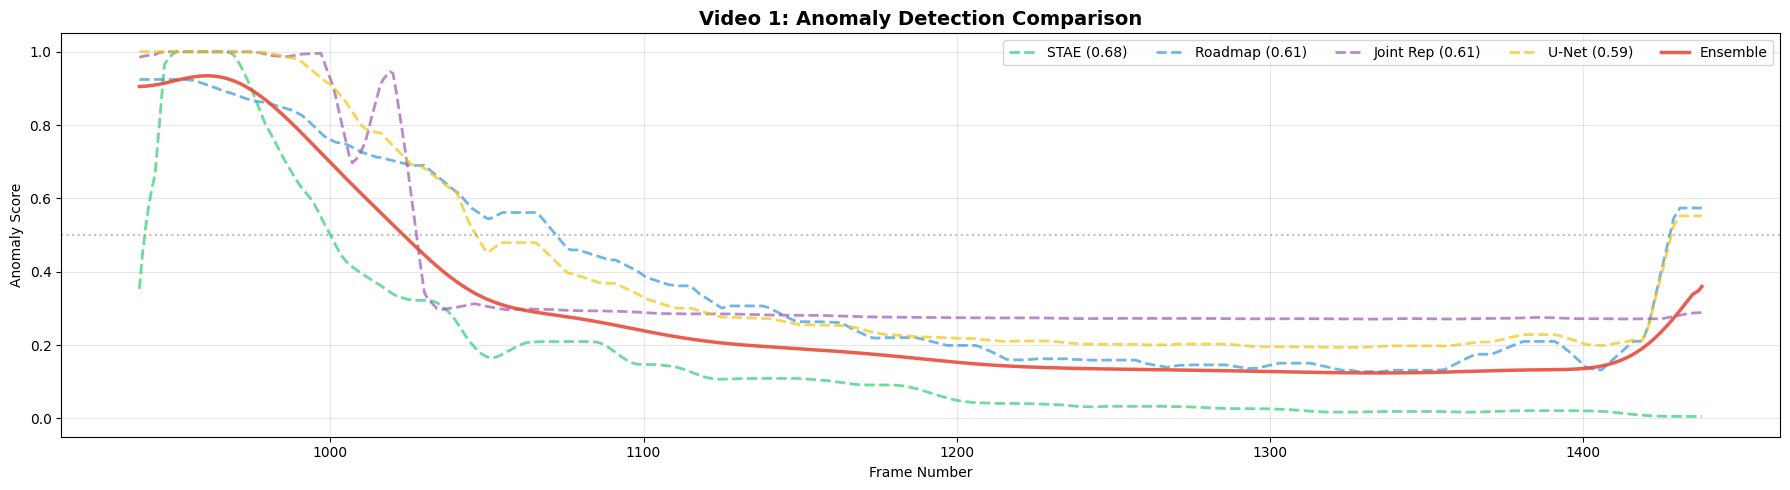

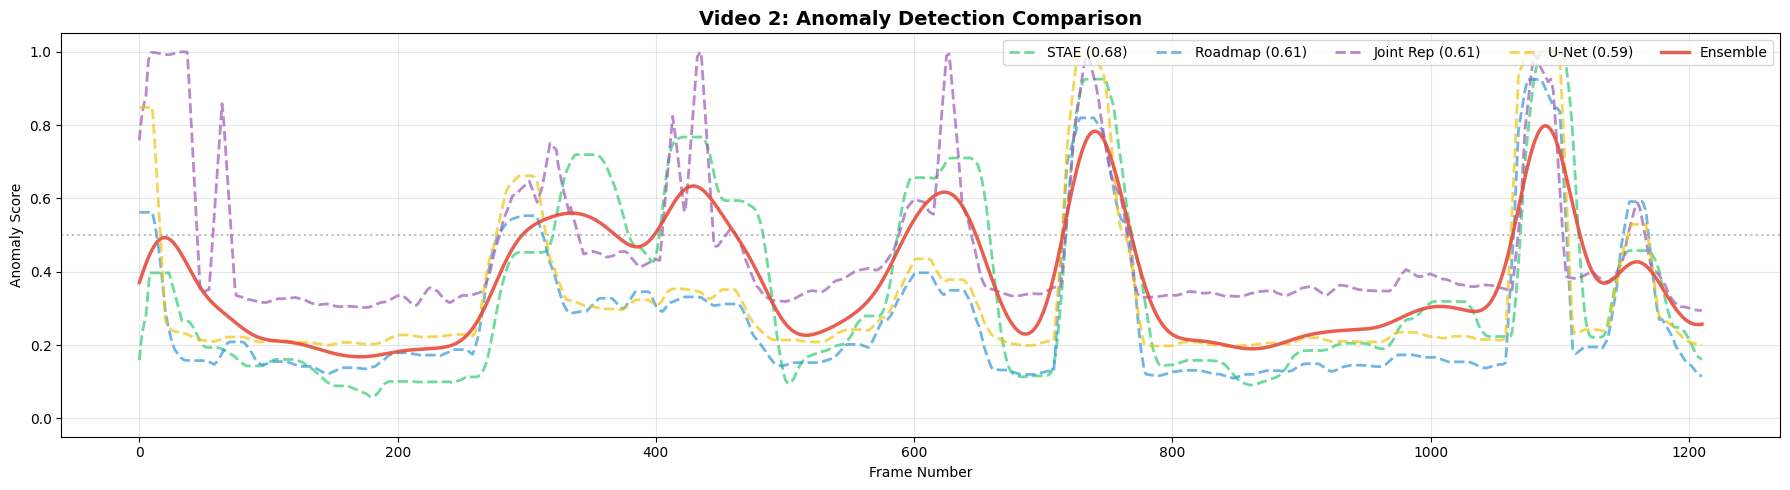

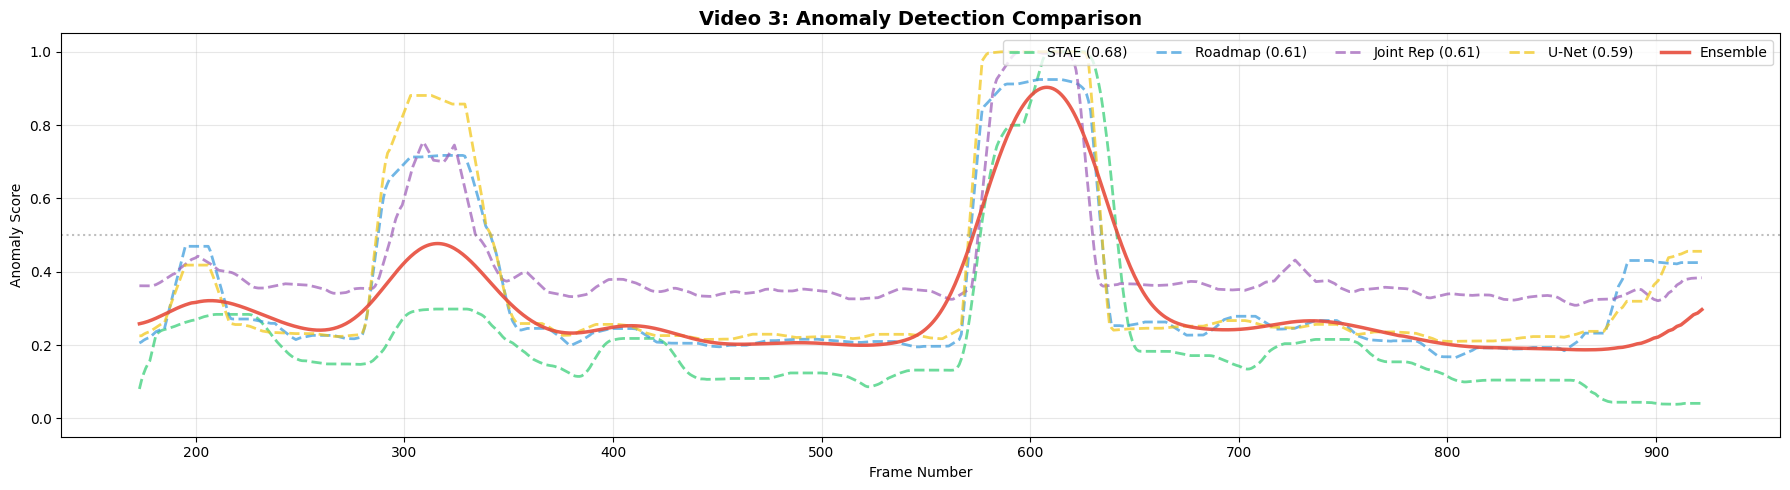

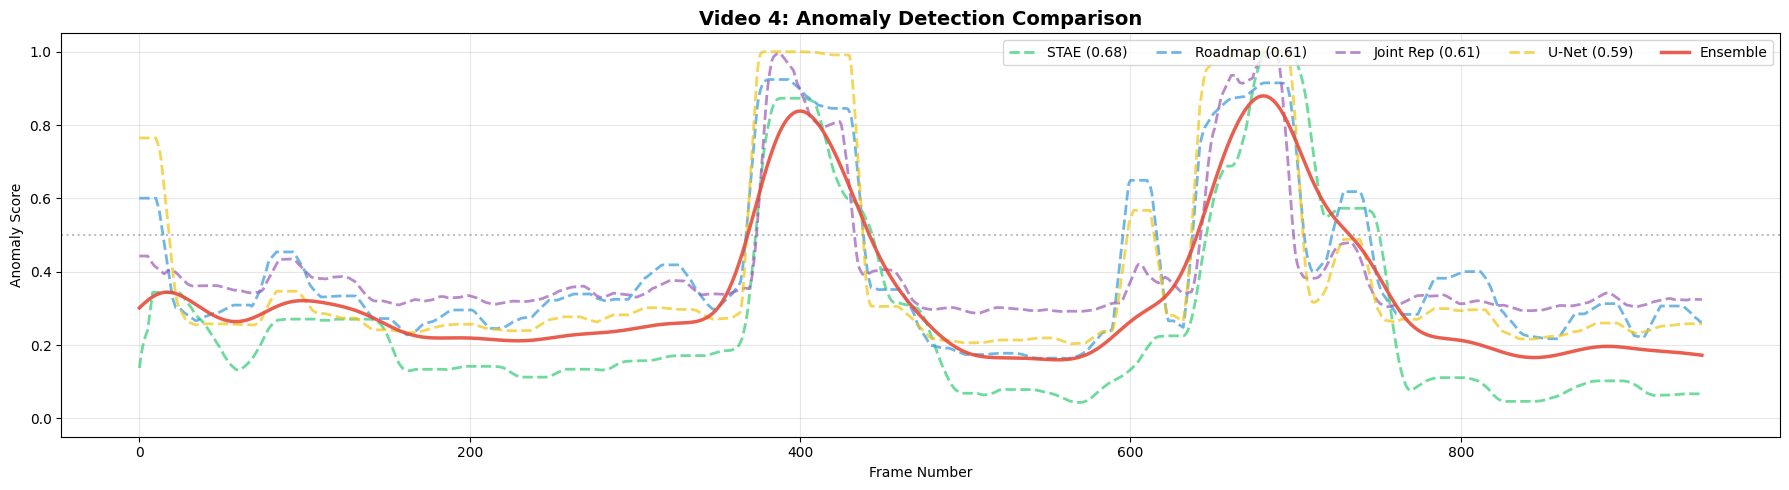

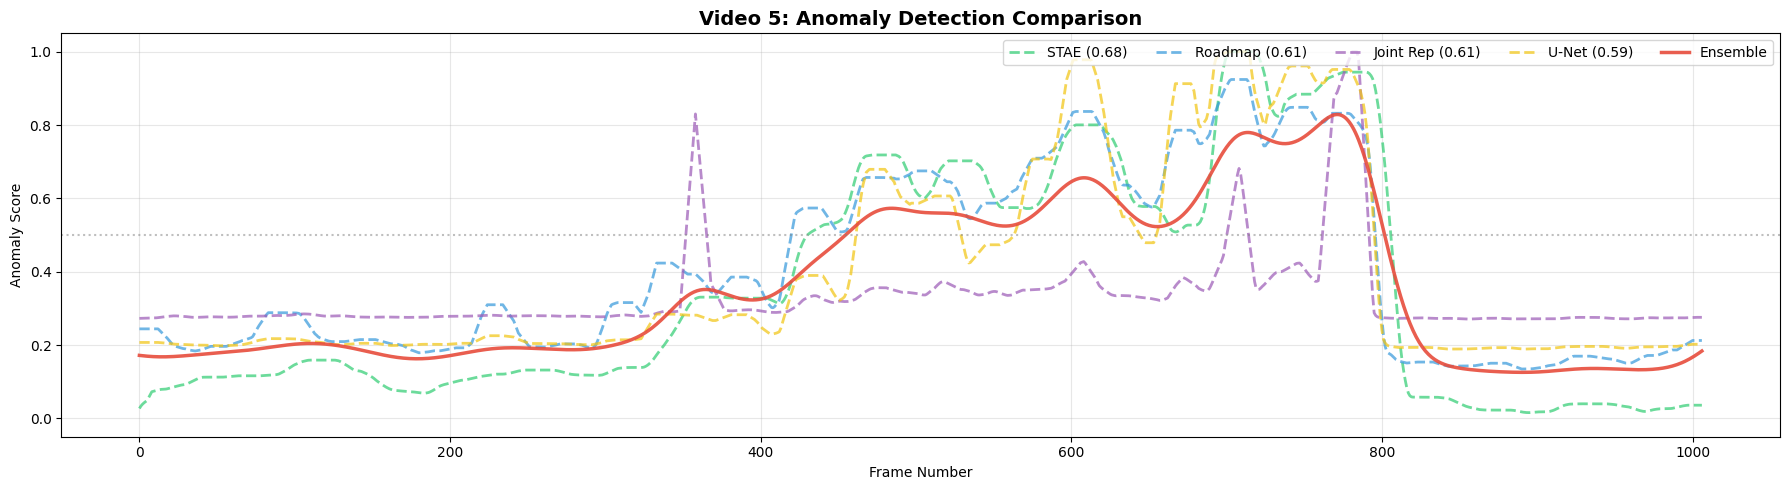

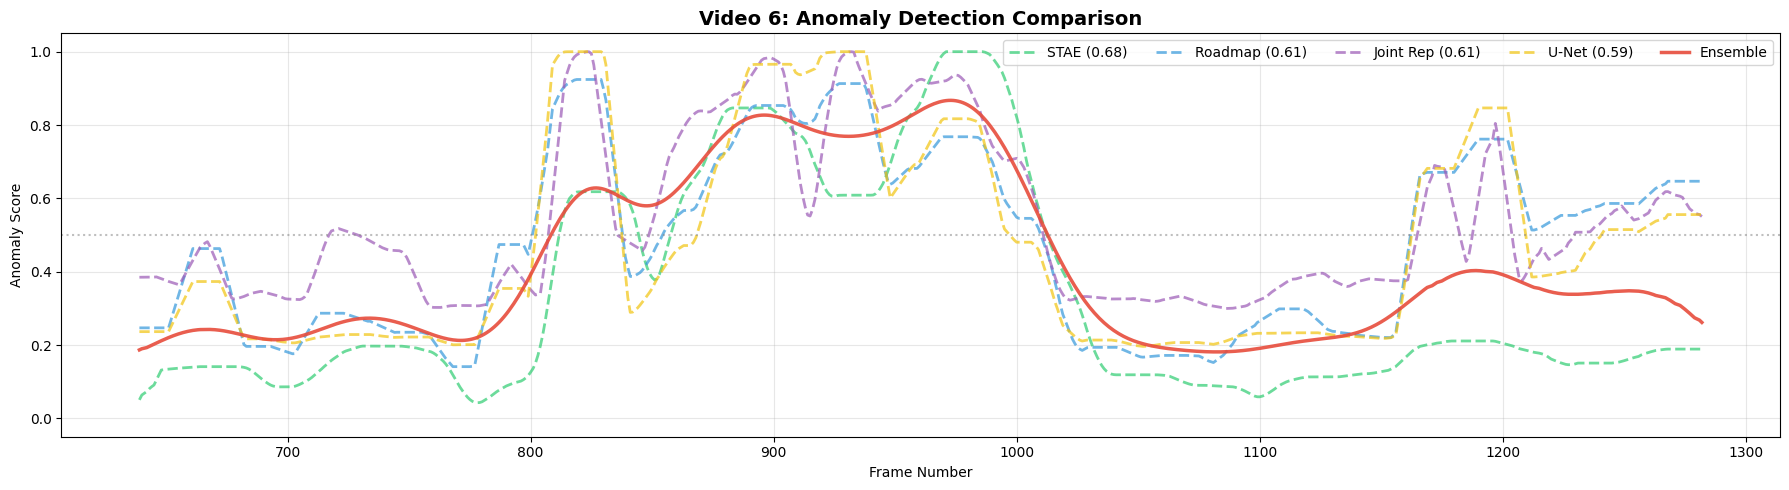

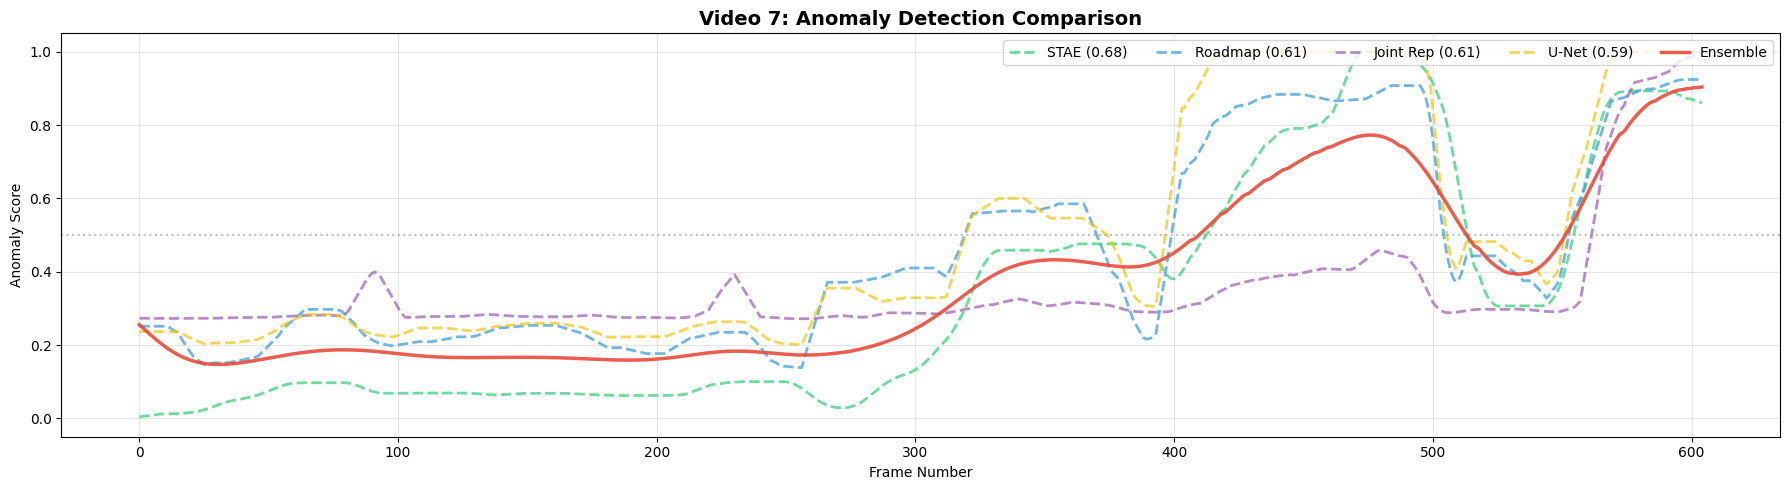

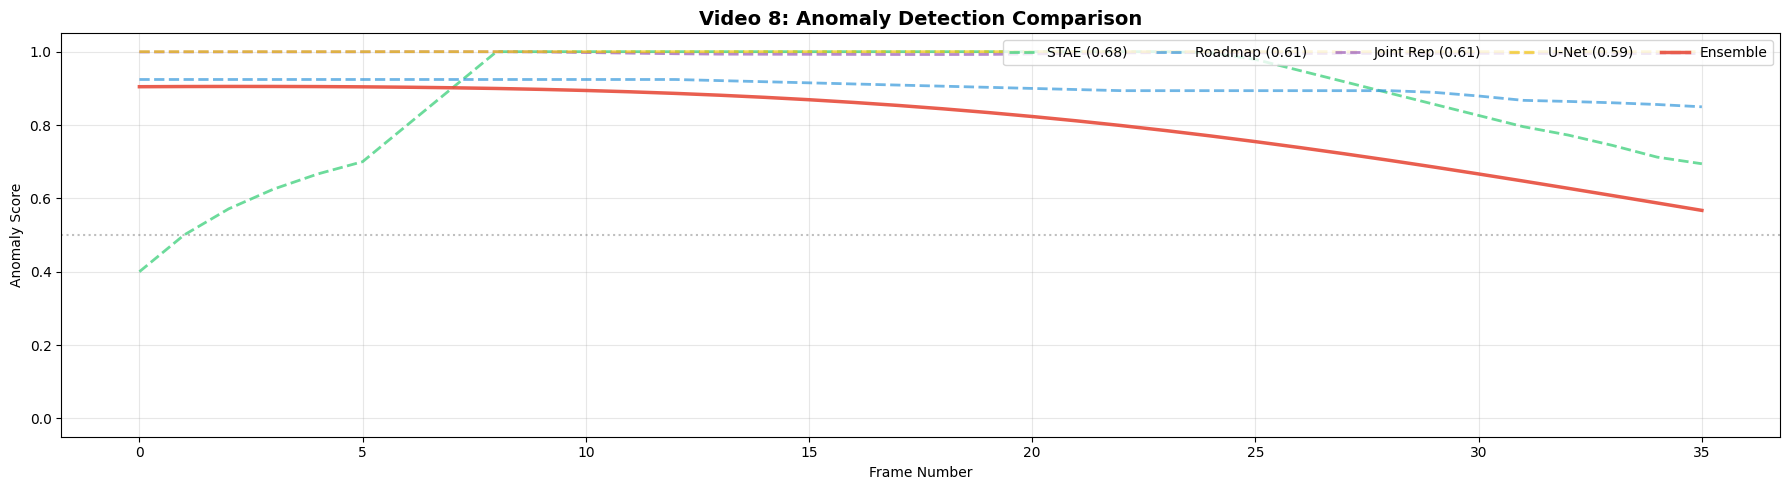

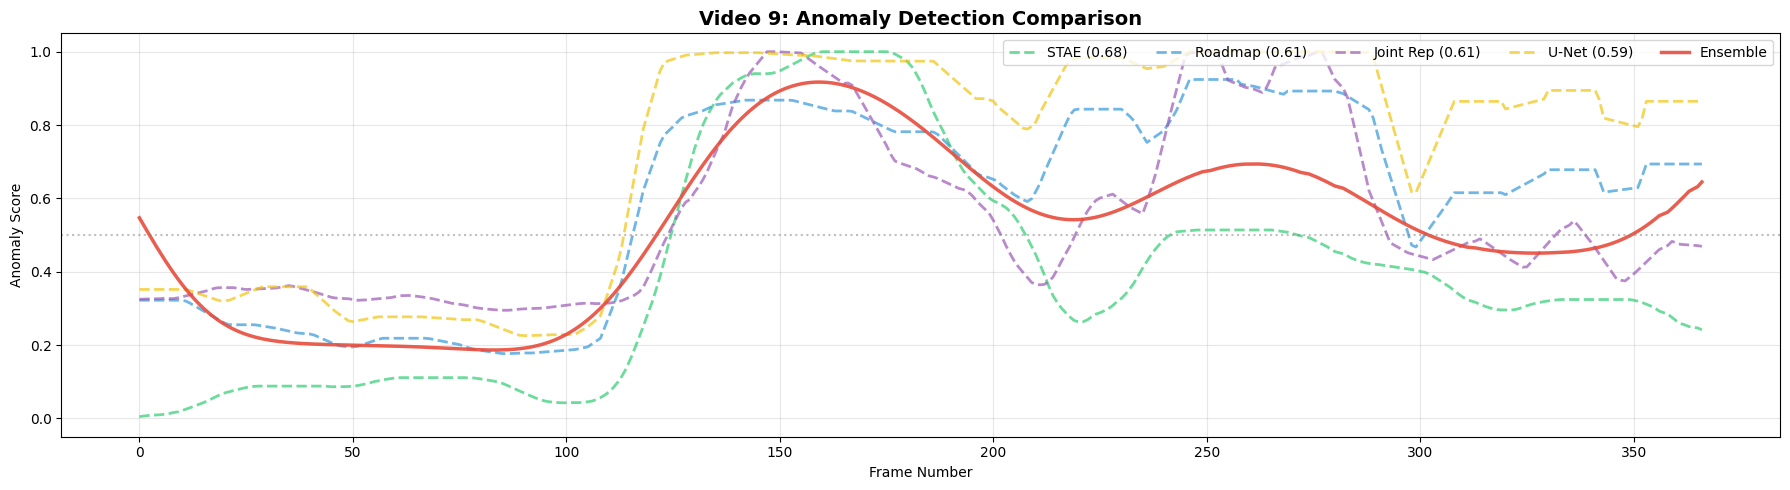

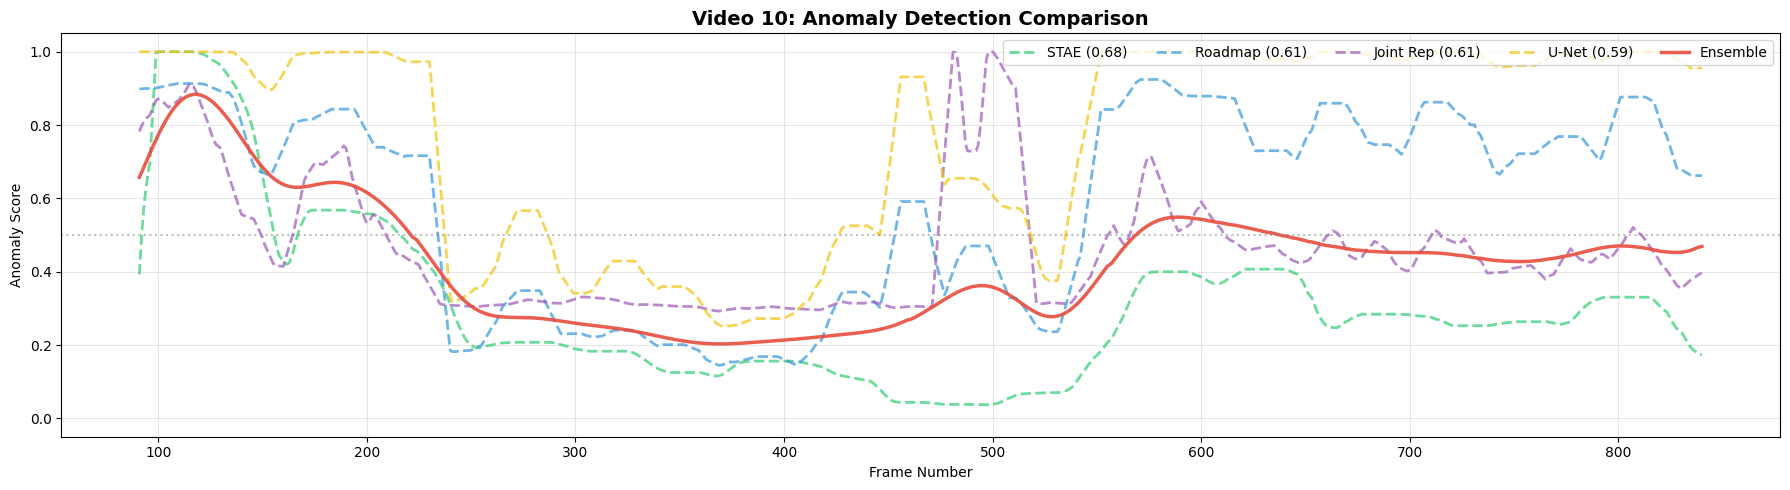

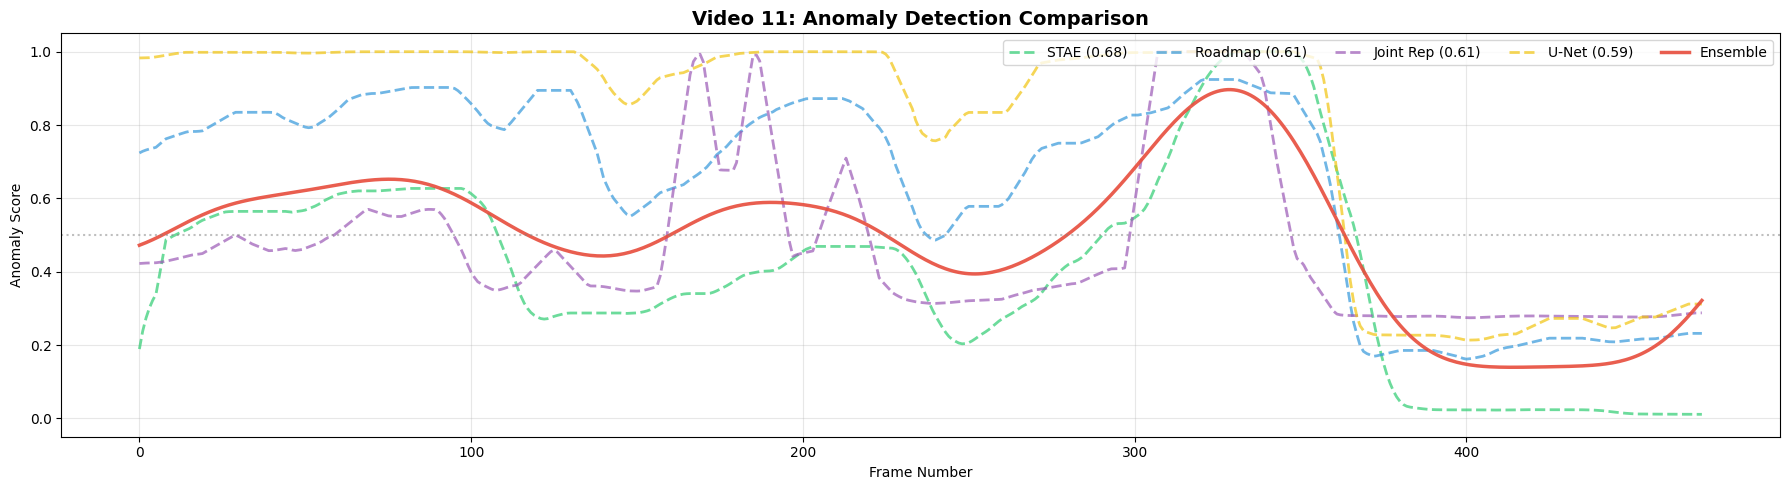

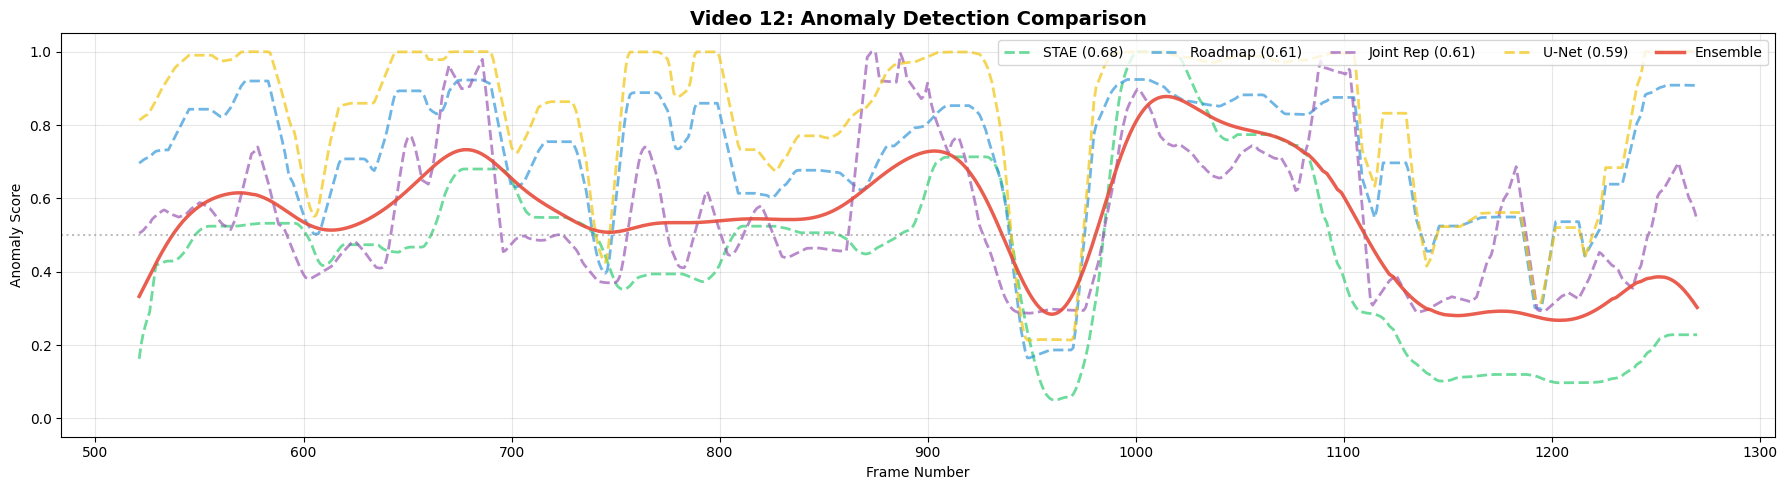

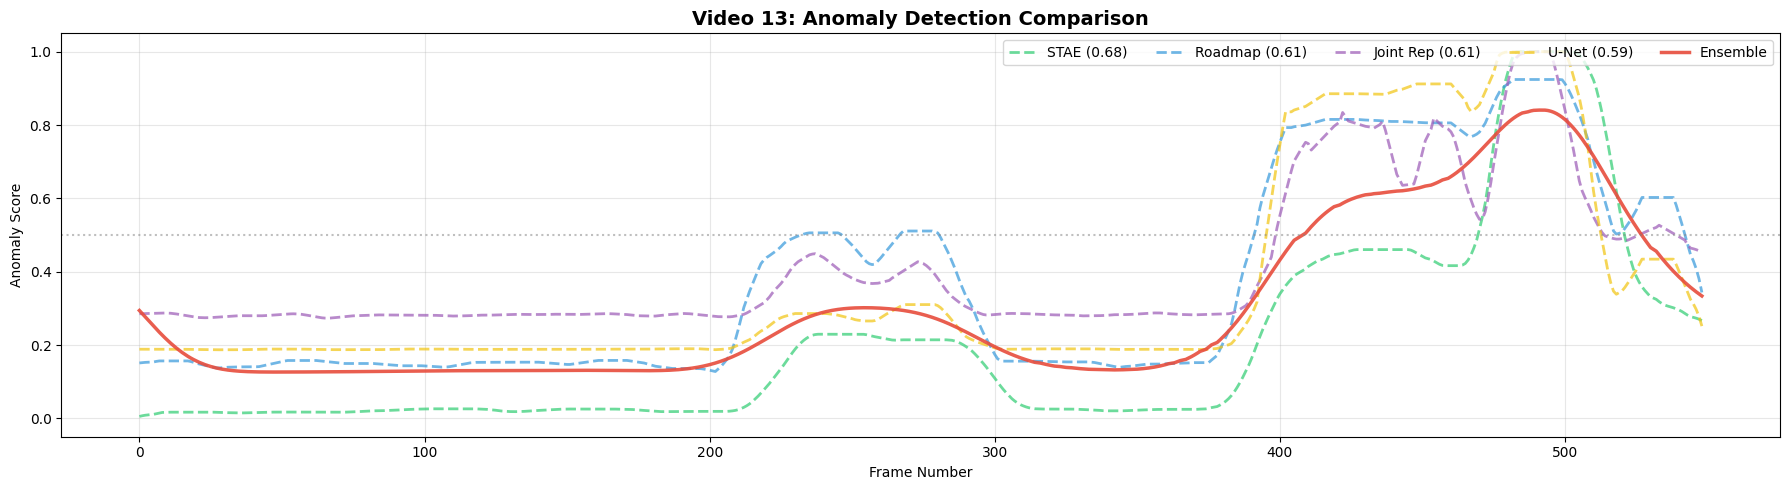

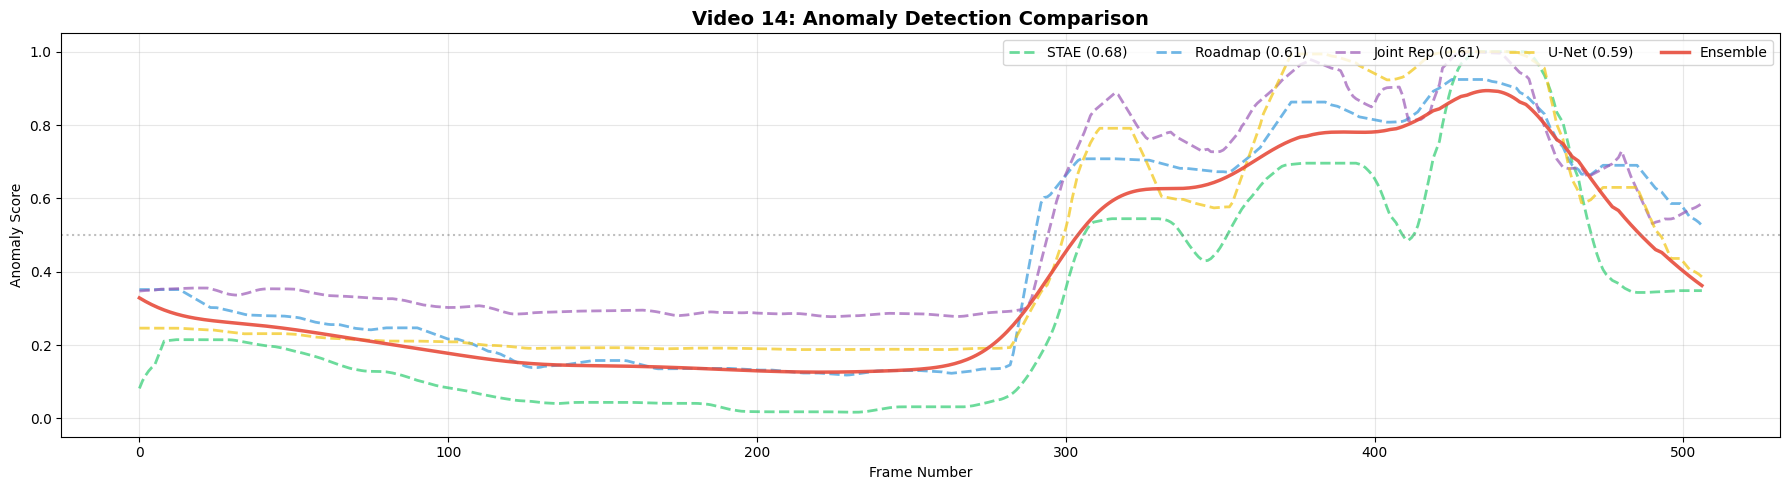

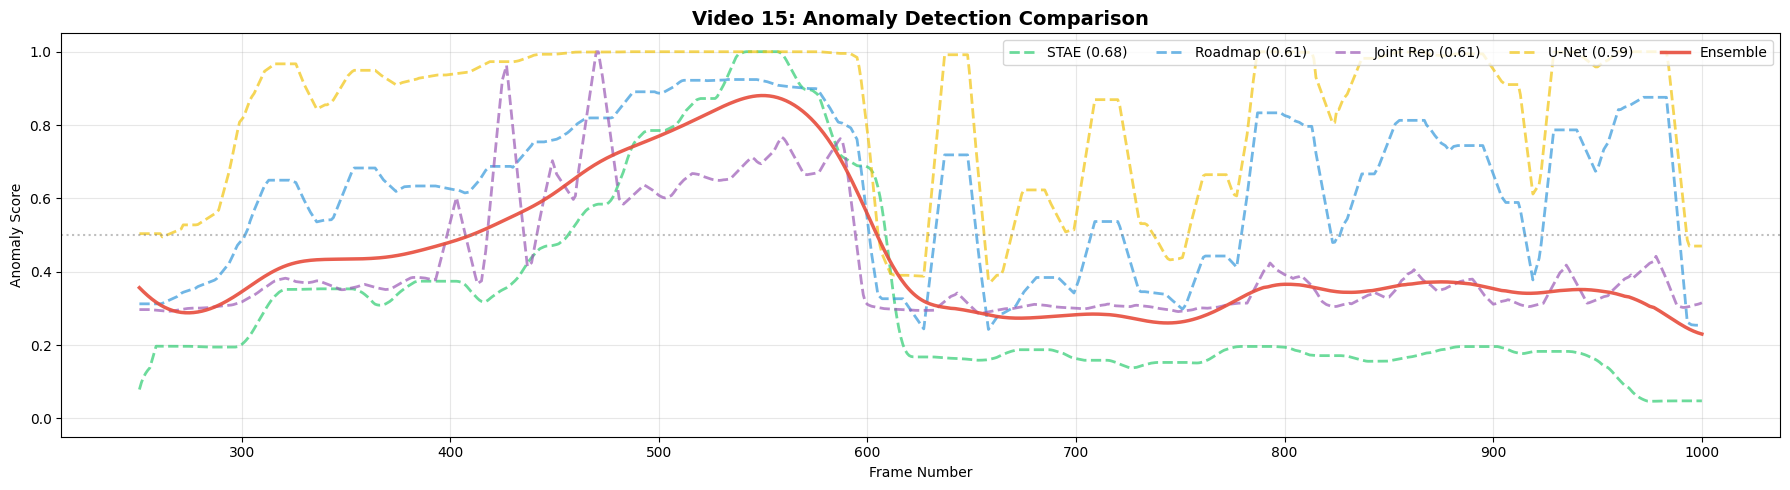

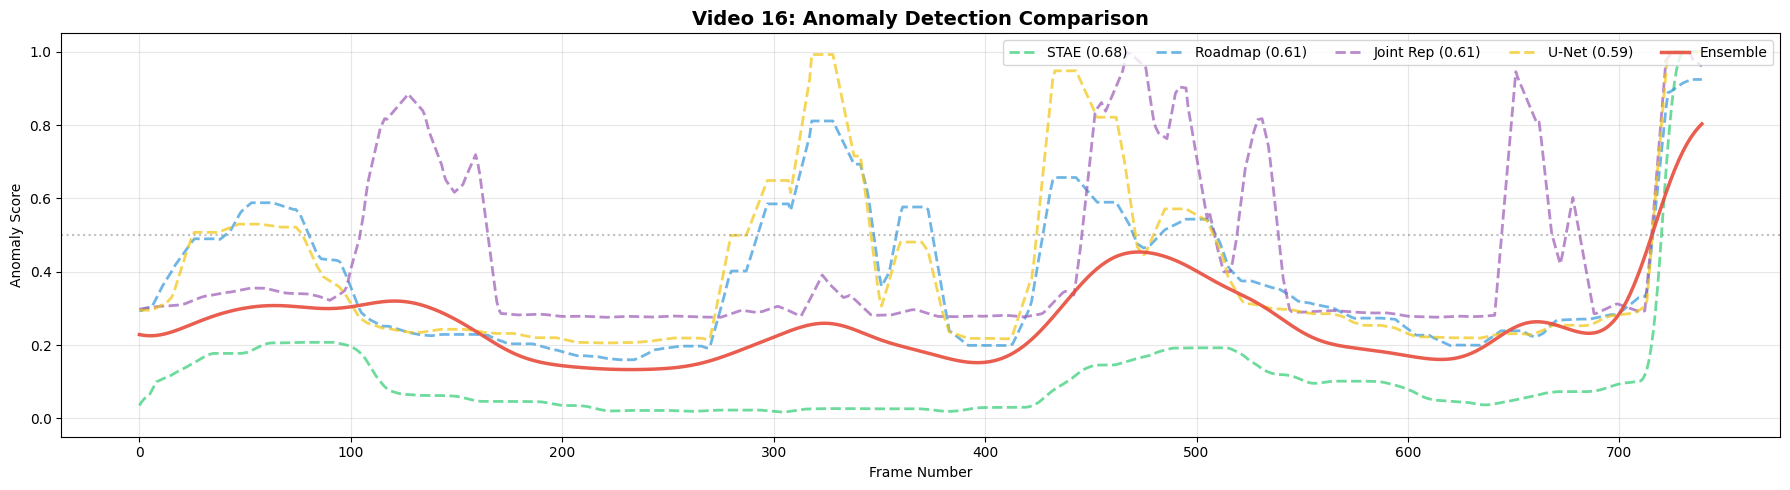

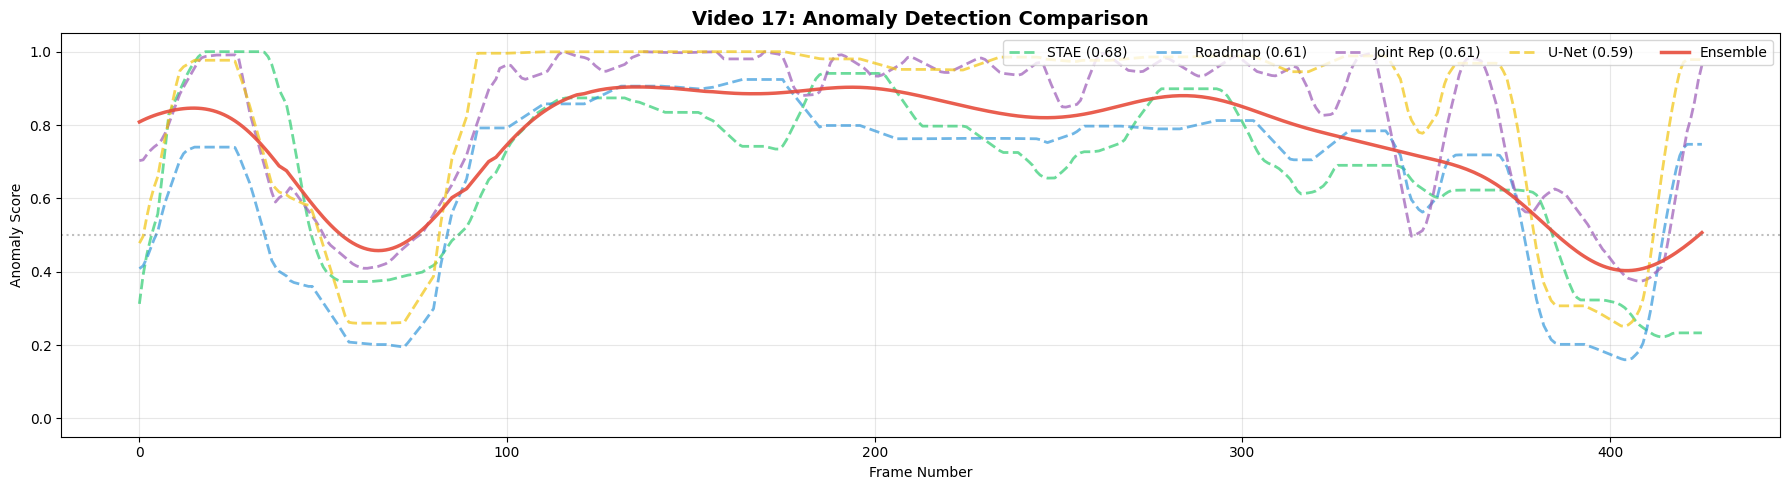

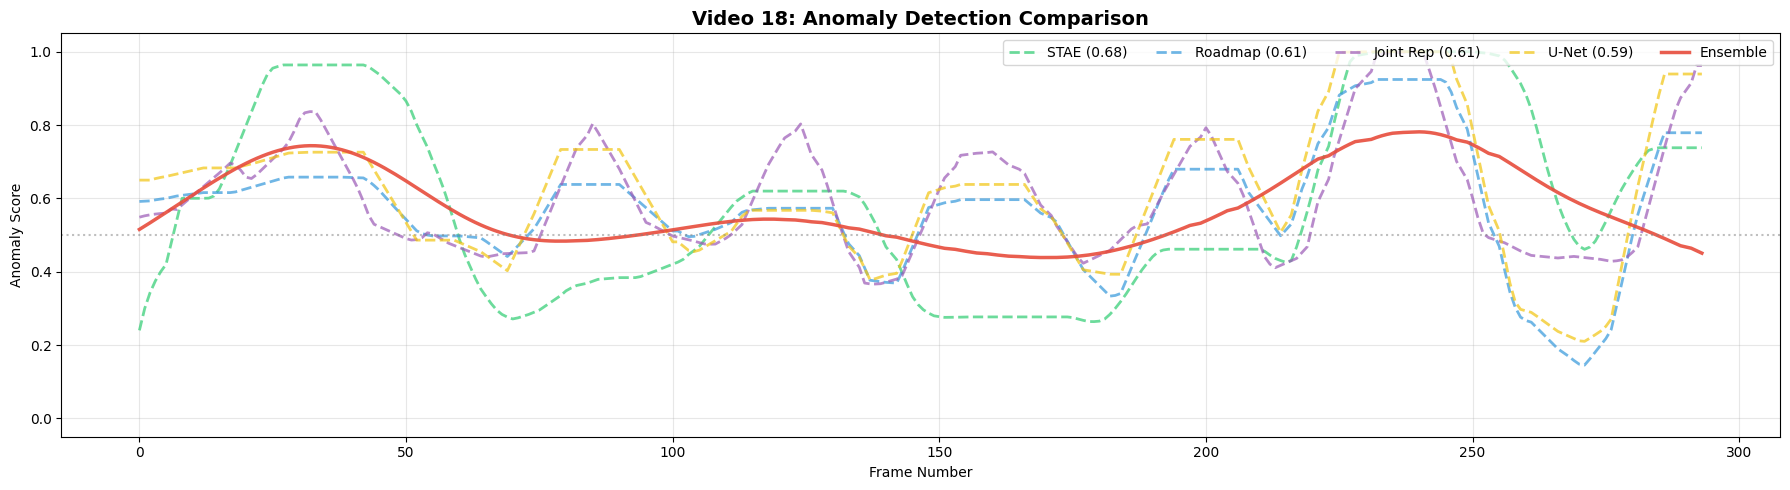

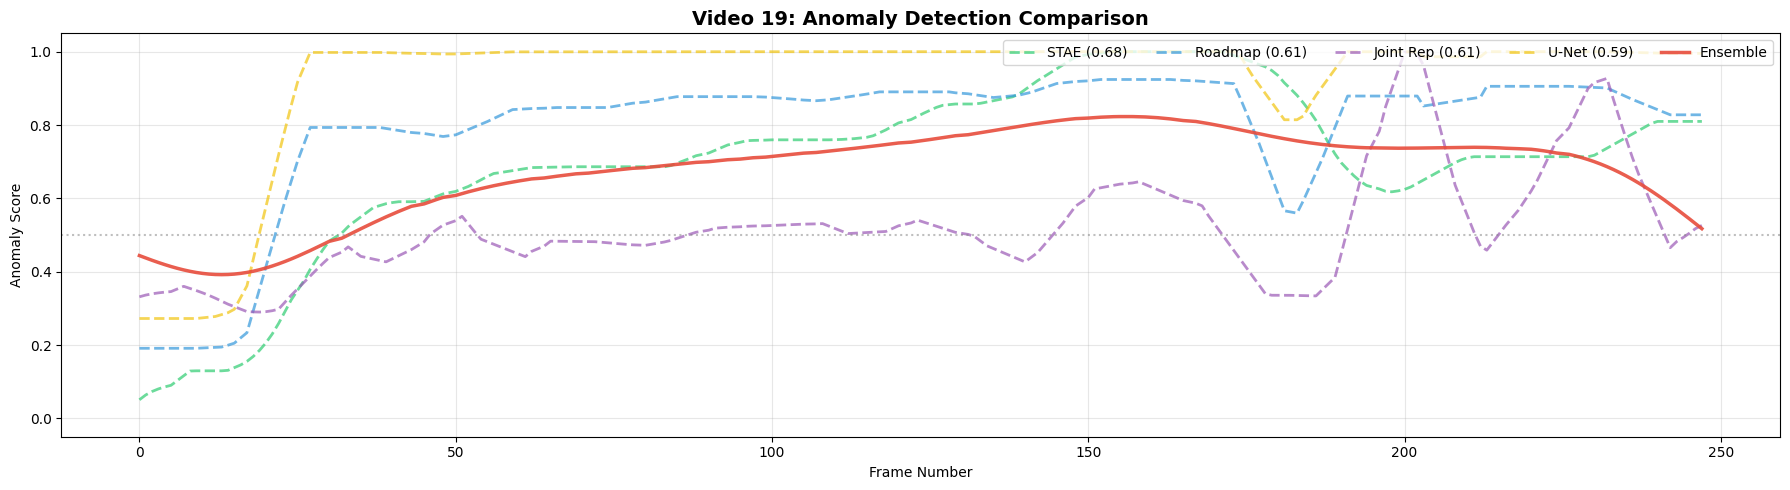

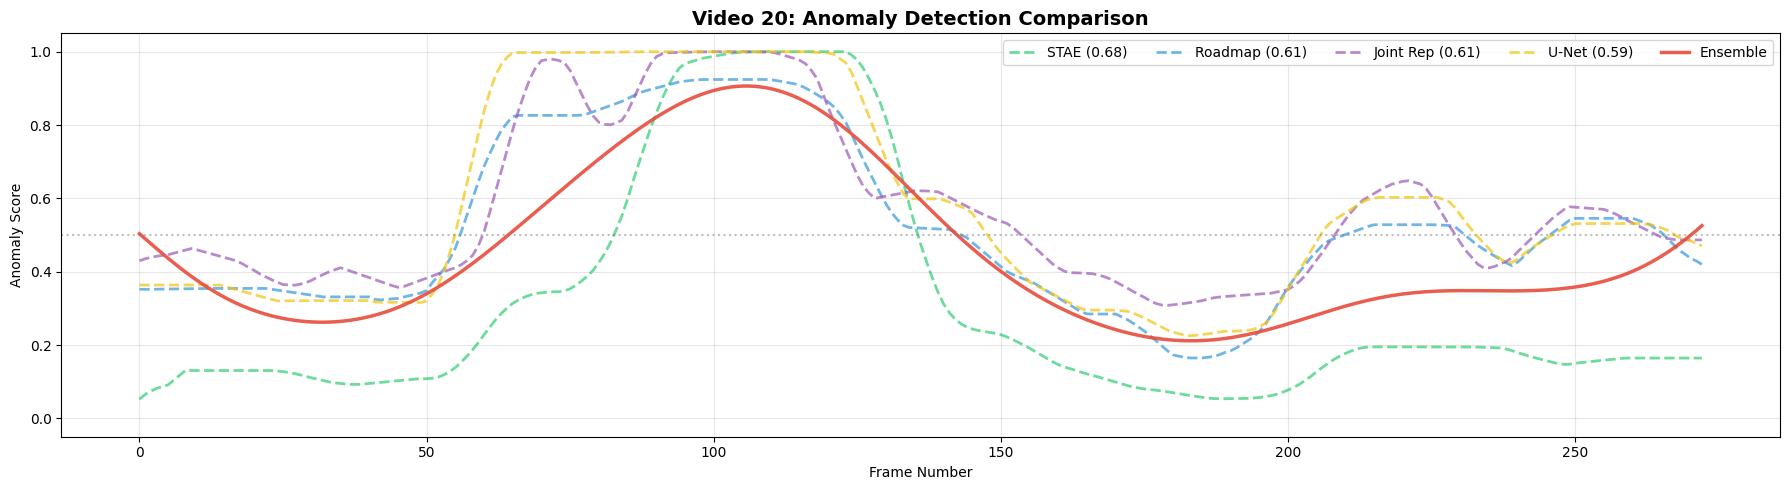

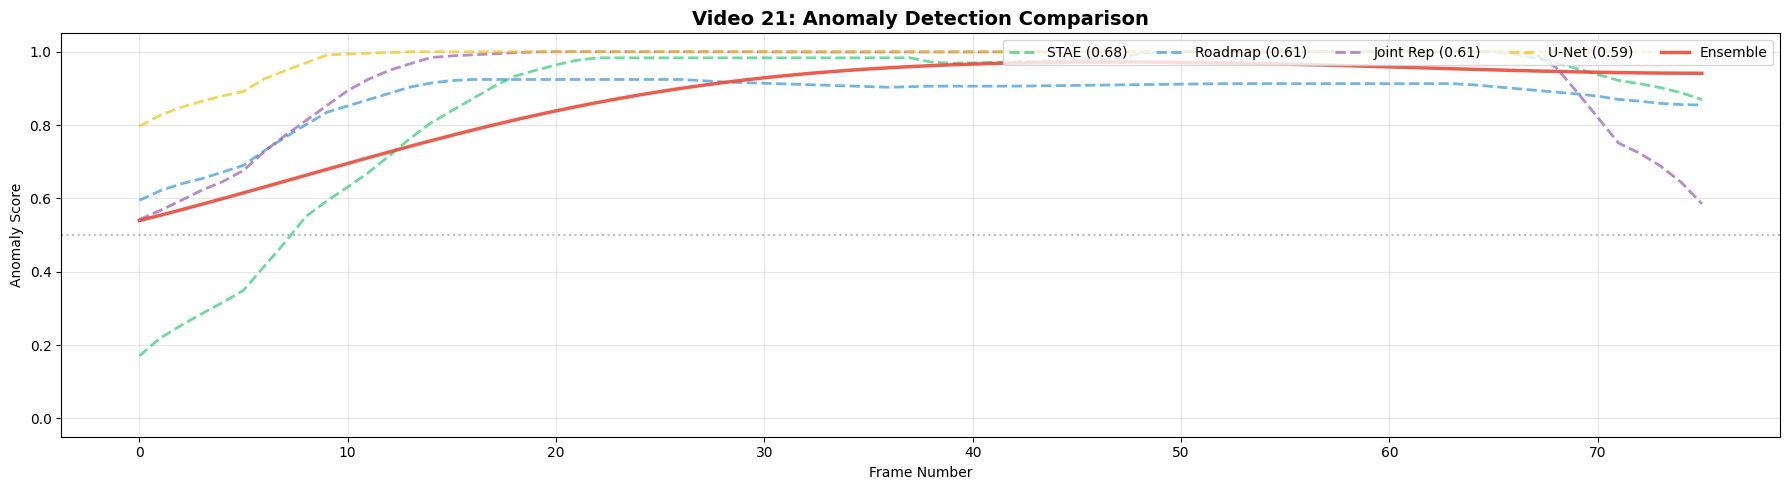

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# ================= CONFIGURATION =================
FILES = {
    'STAE (0.68)': '/kaggle/input/vlg-0-68-2/submission_boosted(1).csv',
    'Roadmap (0.61)': '/kaggle/input/vlg-roadnet-final/submission_boosted2 (7).csv',
    'Joint Rep (0.61)': '/kaggle/input/jr-final-2/submission_boosted2 (14).csv',
    'U-Net (0.59)': '/kaggle/input/unet-final2/submission_boosted2 (10).csv',
    'Ensemble': '/kaggle/working/submission_quad_ensemble.csv'
}

# Colors for consistency
COLORS = {
    'STAE (0.68)': '#2ecc71',      # Green
    'Roadmap (0.61)': '#3498db',   # Blue
    'Joint Rep (0.61)': '#9b59b6', # Purple
    'U-Net (0.59)': '#f1c40f',     # Yellow
    'Ensemble': '#e74c3c'          # Red (Bold)
}
# =================================================

def load_and_prep_data():
    data_cache = {}
    print("⏳ Loading all CSV files into memory...")
    
    all_video_ids = set()
    
    for label, path in FILES.items():
        if not os.path.exists(path):
            print(f"⚠️ Warning: {path} not found. Skipping.")
            continue
            
        try:
            df = pd.read_csv(path)
            # Parse ID -> VideoID, Frame
            df[['VideoID', 'Frame']] = df['ID'].str.split('_', expand=True).astype(int)
            
            # Store grouped by VideoID for fast access
            data_cache[label] = {vid: group for vid, group in df.groupby('VideoID')}
            
            # Keep track of all unique videos found
            all_video_ids.update(df['VideoID'].unique())
            
        except Exception as e:
            print(f"❌ Error processing {label}: {e}")
            
    return data_cache, sorted(list(all_video_ids))

def plot_all_videos():
    # 1. Load Data
    data_map, video_ids = load_and_prep_data()
    
    if not video_ids:
        print("❌ No video IDs found. Check your CSV files.")
        return

    print(f"✅ Found {len(video_ids)} Videos: {video_ids}")
    
    # 2. Iterate and Plot
    for vid in video_ids:
        plt.figure(figsize=(18, 5))
        
        has_data = False
        
        for label, video_groups in data_map.items():
            if vid in video_groups:
                video_df = video_groups[vid].sort_values('Frame')
                
                frames = video_df['Frame'].values
                scores = video_df['Predicted'].values
                
                # Styling
                lw = 2.5 if label == 'Ensemble' else 2
                alpha = 0.9 if label == 'Ensemble' else 0.7
                ls = '-' if label == 'Ensemble' else '--'
                
                plt.plot(frames, scores, label=label, color=COLORS.get(label, 'black'), 
                         linewidth=lw, alpha=alpha, linestyle=ls)
                has_data = True
        
        if not has_data:
            plt.close()
            continue

        # Graph Cosmetics
        plt.title(f"Video {vid}: Anomaly Detection Comparison", fontsize=14, fontweight='bold')
        plt.xlabel("Frame Number")
        plt.ylabel("Anomaly Score")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right', fontsize=10, ncol=5) # Horizontal legend
        
        # Draw threshold line
        plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
        
        plt.tight_layout()
        plt.show() # Display plot for this video immediately

if __name__ == "__main__":
    plot_all_videos()

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Apply this to your final 'Predicted' column
# sigma=2 is usually the "magic number" for 30fps videos (Avenue)
df['Predicted'] = gaussian_filter1d(df['Predicted'], sigma=2)